# I. INTRODUCTION

Real-world data rarely comes clean. Using Python and its libraries, you will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. I will document your wrangling efforts in a Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and/or SQL.

The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for you to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017. 

# II. GATHER DATA

In [92]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
from timeit import default_timer as timer
from tweepy import OAuthHandler

In [17]:
pip install tweepy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tweepy
from tweepy import OAuthHandler

# Enhanced Twitter Archive


Enhanced Twitter Archive

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).

In [246]:
#READ TWITTER ARCHIVE FILE
df = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

# Image Predictions File

Image Predictions File

One more cool thing: I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [94]:
#Read image file
Image = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

with open('image-predictions.tsv', mode='wb') as file:
    file.write(Image.content)

In [95]:
#Read image file
image_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [10]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Definition of the attributes: 
- p1 is the algorithm's #1 prediction for the image in the tweet
- p1_conf is how confident the algorithm is in its #1 prediction
- p1_dog is whether or not the #1 prediction is a breed of dog
- p2 is the algorithm's second most likely prediction
- p2_conf is how confident the algorithm is in its #2 prediction
- p2_dog is whether or not the #2 prediction is a breed of dog 
etc.

# Data extraction from Twitter API

In [37]:

consumer_key = 'xxxx'
consumer_secret = 'xxxx'
access_token = 'xxxx'
access_secret = 'xxxx'

In [40]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [41]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df.tweet_id.values
len(tweet_ids)

2356

In [42]:
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

In [49]:

df_tweet_json = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet-json.txt') as data_file:
    for line in data_file:
        tweet = json.loads(line)
        tweet_id = tweet['id_str']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        df_tweet_json = df_tweet_json.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]],
        columns=['tweet_id', 'retweet_count', 'favorite_count']))
        df_tweet_json = df_tweet_json.reset_index(drop=True)

In [52]:
tweet_count = df_tweet_json[['tweet_id', 'retweet_count', 'favorite_count']]
tweet_count

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


# III. ASSESSING

In [70]:
#Assesing Archive Tweet file
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [63]:

df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [79]:
sum(df.duplicated())

0

In [80]:
sum(df['tweet_id'].duplicated())

0

1. Data is missing in the some columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, etweeted_status_user_id, retweeted_status_timestamp, expanded_urls
2. Wrong format. Source columns have HTML tags
3. Duplicated data.This dataset includes retweets, which means there is duplicated data 

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [69]:
df.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

4. Wrong data type. Timestamp and retweeted_status_timestamp is an object instead of datetime

In [64]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000



5. Invalid Range: rating_numerator contains max value 1776 and rating_denominator contains max value of 17
rating_denominator is out of standard value of 10 at some places which can be Inaccurate data
Note : rating_denominator value needs to be in a standard value of 10 which is the standard for WeRateDogs too for a better and justified analysis

In [61]:
df['name'].value_counts()
print(df['name'].value_counts())

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
           ... 
Stella        1
Ralphson      1
Gustaf        1
Sailer        1
Tove          1
Name: name, Length: 957, dtype: int64


In [65]:

df[df.name.str.islower()].name.value_counts()

a               55
the              8
an               7
very             5
quite            4
one              4
just             4
getting          2
actually         2
mad              2
not              2
light            1
such             1
his              1
all              1
by               1
unacceptable     1
incredibly       1
infuriating      1
space            1
life             1
my               1
officially       1
this             1
old              1
Name: name, dtype: int64

6. Some of dogs have unnormal name such as 'None', or 'a', or 'an.' or 'O' or 'by' and some more lower case words as names

In [71]:
#Assessing tweet Json file
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


7. Tweet ID is object instead of int64

In [67]:
df_tweet_json.describe()

,tweet_id,retweet_count,favorite_count
count,2354,2354,2354
unique,2354,1724,2007
top,671166507850801152,3652,0
freq,1,5,179


In [68]:
df_tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [72]:
#Assessing Image file
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


8. Inconsistent and wrong format of typing. Some are uppercase, some are lower case. Use "_" instead of " "

In [73]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [74]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [77]:
# checks for duplicated entries in image_df
sum(image_df.duplicated())

0

# Summary - Quality Issues

Archive tweet file

1 & 2 Data is missing in the some columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, etweeted_status_user_id, retweeted_status_timestamp, expanded_urls. Duplicated data.This dataset includes retweets, which means there is duplicated data
3. Wrong format. Source columns have HTML tags

4. Wrong data type. Timestamp and retweeted_status_timestamp is an object instead of datetime
5. Invalid Range: rating_numerator contains max value 1776 and rating_denominator contains max value of 17 rating_denominator is out of standard value of 10 at some places which can be Inaccurate data and there are 6 instances of incorrectly entered rating_numerator values
6. Some of dogs have unnormal name such as 'None', or 'a', or 'an.' or 'O' or 'by' and some more lower case words as names

JSON file:

7. Tweet ID is object instead of int64

Image file

8. Inconsistent and wrong format of typing. Some are uppercase, some are lower case. Use "_" instead of " "

# Summary - Tidiness Issues

#SUMMARY - TIDINESS ISSUES

df:
1)The variable for the dog's stage (dogoo, floofer, pupper, puppo) is spread in different columns

image_df:
   2)This data set is part of the same observational unit as the data in the archive_df 

df_tweet_json:
3)This data set is also part of the same observational unit as the data in the archive_df 

# IV. CLEANING

In [99]:
#Make a copy before cleaning

clean_df= df.copy()
clean_image_df = image_df.copy()
clean_tweet_json = df_tweet_json.copy()

In [162]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2244 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2244 non-null int64
timestamp             2244 non-null datetime64[ns, UTC]
source                2244 non-null object
text                  2244 non-null object
expanded_urls         2185 non-null object
rating_numerator      2244 non-null int64
rating_denominator    2244 non-null int64
name                  1429 non-null object
doggo                 2244 non-null object
floofer               2244 non-null object
pupper                2244 non-null object
puppo                 2244 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 227.9+ KB


# Define- Code - Test

1. Remove unessentual attributes: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp

2. Removing HTML tags from source column

3. Delete retweets

4. Change the timestamp to correct datetime format

5. Dog ratings get standardized for denom of 10

6. Replace 'a', 'an', 'the', 'None' and other lower case words with NaN in name column

7. Convert the tweet_id in tweet_counts_clean into int64 type for merging

8. Create one column for the various dog types: doggo, floofer, pupper, puppo, 'doggo, puppo', 'doggo, pupper', 'doggo, floofer'


9 & 10. Merge the copied df_clean, image_df_clean, and tweet_json_clean dataframes

In [196]:
#1. Convert the tweet_id in tweet_counts_clean into int64 type for merging
clean_tweet_json['tweet_id'] = clean_tweet_json['tweet_id'].astype('int64')

In [249]:
#Test
clean_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: int64(1), object(2)
memory usage: 55.3+ KB


In [ ]:
# 2.Drop the unnecessary columns
clean_df = clean_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_user_id'], axis=1)

In [ ]:
# 3. Convert timestamp datatype to datetime
clean_df.timestamp = pd.to_datetime(clean_df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [181]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2237 non-null int64
timestamp             2237 non-null datetime64[ns, UTC]
source                2237 non-null object
text                  2237 non-null object
expanded_urls         2182 non-null object
rating_numerator      2237 non-null float64
rating_denominator    2237 non-null int64
name                  1427 non-null object
doggo                 2237 non-null object
floofer               2237 non-null object
pupper                2237 non-null object
puppo                 2237 non-null object
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(8)
memory usage: 227.2+ KB


Remove the observations where tweet_id matches retweeted_status_id

In [106]:
# 4. Remove the observations where tweet_id matches retweeted_status_id
# Seperate out the series of retweeted_status_id to match later
retweet_clean = clean_df.retweeted_status_id

retweet_clean = retweet_clean.dropna()

retweet_clean = retweet_clean.astype('int64')

In [107]:
# Drop the observations where tweet_id matches the above seperated series
clean_df = clean_df.drop(clean_df[clean_df.tweet_id.apply(lambda x : x in retweet_clean.values)].index.values, axis=0)


In [108]:
#Drop retweet_status_id
clean_df = clean_df.drop('retweeted_status_id', axis=1)

In [153]:

# Drop retweeted_status_timestamp
clean_df = clean_df.drop('retweeted_status_timestamp', axis=1)

In [157]:
clean_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27+00:00,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24+00:00,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [111]:
# 5. Check for invalid names
clean_df[clean_df.name.str.islower() == True].name.value_counts()

a               55
the              8
an               6
very             5
one              4
quite            3
just             3
not              2
getting          2
actually         2
by               1
this             1
officially       1
life             1
old              1
his              1
such             1
light            1
all              1
unacceptable     1
incredibly       1
infuriating      1
space            1
my               1
mad              1
Name: name, dtype: int64

In [113]:
# Replace the invalid names with a string 'None'
for item in clean_df.name:
    if item.islower() == True:
        clean_df.name = clean_df.name.replace(item, 'None')

In [114]:
# Replace 'None' string in the name column with NaN value
clean_df.name = clean_df.name.replace('None', np.nan)

In [115]:
clean_df[clean_df.name.str.islower() == True].name.value_counts()

Series([], Name: name, dtype: int64)

In [118]:
sum(clean_df.name.str.islower() == True)

0

In [119]:
sum(clean_df.name.isnull())

815

In [171]:
ratings = clean_df.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [173]:
clean_df.rating_numerator = ratings
clean_df['rating_numerator'] = clean_df['rating_numerator'].astype('float64')

In [248]:
# 6. Standardizing to a denominator of 10 for groups of dogs:

rating_num = [int(round(num/(denom/10)))  if denom != 10 and num/denom <= 2 
                           else num for num, denom in zip(clean_df['rating_numerator'], clean_df['rating_denominator'])]
rating_denom = [10 if denom != 10 and num/denom <= 2
                             else denom for num, denom in zip(clean_df['rating_numerator'], clean_df['rating_denominator'])]
clean_df['rating_numerator'] = rating_num
clean_df['rating_denominator'] = rating_denom

clean_df = clean_df.drop(clean_df[((clean_df['rating_denominator'] != 10) | (clean_df['rating_numerator'] > 20))].index)

In [176]:
#test
clean_df['rating_numerator'].value_counts()

12.00    525
10.00    447
11.00    446
13.00    327
9.00     157
8.00     100
7.00      54
14.00     50
5.00      36
6.00      33
3.00      19
4.00      15
2.00      11
1.00       7
0.00       2
15.00      2
11.27      1
9.50       1
17.00      1
13.50      1
11.26      1
9.75       1
Name: rating_numerator, dtype: int64

In [177]:
clean_df['rating_denominator'].value_counts()

10    2237
Name: rating_denominator, dtype: int64

In [164]:
#7. Format name. Replace the instance of _ with ` and change the values to upper case inp1, p2 and p3
clean_image_df.p1 = clean_image_df.p1.str.replace('_', ' ').str.capitalize()
clean_image_df.p2 = clean_image_df.p2.str.replace('_', ' ').str.capitalize()
clean_image_df.p3 = clean_image_df.p3.str.replace('_', ' ').str.capitalize()

In [166]:
#Test
clean_image_df[['p1', 'p2', 'p3']].sample(20)

,p1,p2,p3
837,Boxer,Bull mastiff,Saint bernard
1044,Great pyrenees,Kuvasz,Irish wolfhound
245,Minivan,Beach wagon,Car wheel
1664,Bath towel,Pillow,Great dane
2058,Golden retriever,Tibetan mastiff,Labrador retriever
1238,Dingo,Timber wolf,Ibizan hound
2074,Orange,Bagel,Banana
1539,Dishwasher,Golden retriever,Chow
1242,Coil,Dugong,Rain barrel
1167,Pembroke,Seat belt,Cardigan


In [251]:

# 8.One variable in 4 columns - dog_stage(doggo, floofer, pupper, puppo)

In [184]:
# Replace the NaNs with empty string
clean_df[['doggo', 'floofer', 'pupper', 'puppo']] = clean_df[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')

In [185]:
# Combine the columns into one column
clean_df['dog_stage'] = clean_df['doggo'] + clean_df['floofer'] + clean_df['pupper'] + clean_df['puppo']

In [186]:
# Drop unnecessary columns
clean_df = clean_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

In [188]:
#Test
clean_df.dog_stage.value_counts()

                1882
pupper           231
doggo             79
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [190]:
clean_df.loc[clean_df.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
clean_df.loc[clean_df.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
clean_df.loc[clean_df.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [191]:
#test
clean_df.dog_stage.value_counts()

                  1882
pupper             231
doggo               79
puppo               24
doggo, pupper       10
floofer              9
doggo, floofer       1
doggo, puppo         1
Name: dog_stage, dtype: int64

In [192]:
clean_df.dog_stage.dtype

dtype('O')

In [ ]:
# 9.Check the distribution of source values 
clean_df.source.value_counts()

In [ ]:
clean_df.source = clean_df.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
clean_df.source = clean_df.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine - Make a Scene')
clean_df.source = clean_df.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
clean_df.source = clean_df.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

In [ ]:
#TEST
clean_df.source.value_counts()

In [198]:
#10 & 11 Merge the copied df_clean, image_df_clean, and tweet_json_clean dataframes
from functools import reduce
data = [clean_df, clean_image_df, clean_tweet_json]
data_df = reduce(lambda left, right:  pd.merge(left, right,on = 'tweet_id'), data)

In [199]:
#test
data_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27+00:00,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,4328,25461
3,891689557279858688,2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,...,0.170278,False,Labrador retriever,0.168086,True,Spatula,0.040836,False,8964,42908
4,891327558926688256,2017-07-29 16:00:24+00:00,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True,9774,41048


In [200]:
#test
data_df.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf
count,1.969000e+03,1969.000000,1969.0,1969.000000,1969.000000,1969.000000,1.969000e+03
mean,7.371736e+17,10.554611,10.0,1.202133,0.593177,0.134028,6.050621e-02
std,6.798196e+16,2.191284,0.0,0.559267,0.272044,0.099926,5.092227e-02
min,6.660209e+17,0.000000,10.0,1.000000,0.044333,0.000010,2.160900e-07
25%,6.758981e+17,10.000000,10.0,1.000000,0.362835,0.054322,1.648340e-02
50%,7.095570e+17,11.000000,10.0,1.000000,0.588230,0.117566,4.981050e-02
75%,7.931355e+17,12.000000,10.0,1.000000,0.841987,0.194207,9.150480e-02
max,8.924206e+17,15.000000,10.0,4.000000,0.999984,0.488014,2.734190e-01


In [255]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 1968
Data columns (total 24 columns):
tweet_id              1969 non-null int64
timestamp             1969 non-null datetime64[ns, UTC]
source                1969 non-null object
text                  1969 non-null object
expanded_urls         1969 non-null object
rating_numerator      1969 non-null float64
rating_denominator    1969 non-null int64
name                  1326 non-null object
dog_stage             1969 non-null object
jpg_url               1969 non-null object
img_num               1969 non-null int64
p1                    1969 non-null object
p1_conf               1969 non-null float64
p1_dog                1969 non-null bool
p2                    1969 non-null object
p2_conf               1969 non-null float64
p2_dog                1969 non-null bool
p3                    1969 non-null object
p3_conf               1969 non-null float64
p3_dog                1969 non-null bool
retweet_count         196

In [256]:
data_df.shape

(1969, 24)

# V. STORE DATA

In [252]:
# storing final as csv
data_df.to_csv('data_df.csv', encoding='utf-8', index=False)

In [ ]:
#TEST

data_df = pd.read_csv('data_df.csv')
data_df.info()

# VI. ANALYZE DATA

# 1. Top frequent dog names

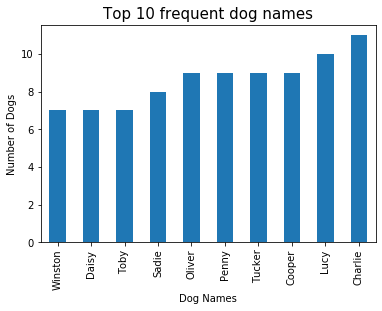

In [204]:
data_df['name'].value_counts()[0:10].sort_values(ascending=True).plot(kind = 'bar')
plt.ylabel('Number of Dogs')
plt.title('Top 10 frequent dog names', size=15)
plt.xlabel('Dog Names')
plt.plot();

This is the top ten frequent dog names including: Charile, Lucy, Cooper, Tucker, Penny, Oliver, Sadie, Toby, Daisy and Winston. Among them, Charlie and Lucy are the two most popular names.

# 2. Average Rating

In [217]:
data_df.dog_stage.value_counts()

                  1672
pupper             197
doggo               63
puppo               19
doggo, pupper        9
floofer              7
doggo, floofer       1
doggo, puppo         1
Name: dog_stage, dtype: int64

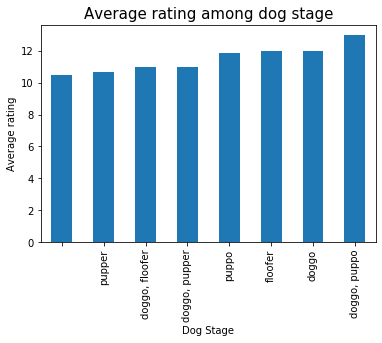

In [208]:
# Create a variable and store the average rating numerator for each dog stage
avg_rating = data_df.groupby('dog_stage').rating_numerator.mean().sort_values(ascending=True).plot(kind = 'bar')
plt.ylabel('Average rating')
plt.title('Average rating among dog stage', size=15)
plt.xlabel('Dog Stage')
plt.plot();

Regarding average rating among dog stage, multiple stage (doggo, puppo) has the highest average rating. Doggo and Floofer ranks second and third repsectively.

# 3. Dog Prediction

The student would like to investigate into dog prediction according to the first prediction. Step includes:
- Identify top 10 most frequently predicted dog types
- Among them, identify good prediction regarding prediction confidence > 0.5 and Prediction is True


In [226]:
data_df.tail()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,text_clear,senti_polarity
1964,666049248165822465,2015-11-16 00:24:50+00:00,666049248165822465,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5.0,10,NaN,,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,...,Rottweiler,0.243682,True,Doberman,0.154629,True,41,111,st generation vulpix enjoys sweat tea fox news cannot phased httpstcobcocedq,0.000000
1965,666044226329800704,2015-11-16 00:04:52+00:00,666044226329800704,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6.0,10,NaN,,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,...,Redbone,0.360687,True,Miniature pinscher,0.222752,True,147,311,purebred piers morgan loves netflix chill always looks like forgot unplug iron httpstcodwnycjfmx,0.000000
1966,666033412701032449,2015-11-15 23:21:54+00:00,666033412701032449,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9.0,10,NaN,,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,...,Malinois,0.138584,True,Bloodhound,0.116197,True,47,128,happy pup big fan wellmaintained decks look tongue would cuddle af httpstcoyymhoir,0.400000
1967,666029285002620928,2015-11-15 23:05:30+00:00,666029285002620928,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10,NaN,,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,...,Miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True,48,132,western brown mitsubishi terrier upset leaf actually dogs would walk shit httpstcormobmui,-0.066667
1968,666020888022790149,2015-11-15 22:32:08+00:00,666020888022790149,Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8.0,10,NaN,,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,...,Collie,0.156665,True,Shetland sheepdog,0.061428,True,532,2535,japanese irish setter lost eye vietnam big fan relaxing stair would pet httpstcobldqewijj,0.000000


In [228]:
#Create first prediction subset with relevant attributes
first_pre = data_df[['tweet_id', 'p1', 'p1_conf', 'p1_dog']]
first_pre.head()

,tweet_id,p1,p1_conf,p1_dog
0,892420643555336193,Orange,0.097049,False
1,892177421306343426,Chihuahua,0.323581,True
2,891815181378084864,Chihuahua,0.716012,True
3,891689557279858688,Paper towel,0.170278,False
4,891327558926688256,Basset,0.555712,True


In [229]:
first_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 1968
Data columns (total 4 columns):
tweet_id    1969 non-null int64
p1          1969 non-null object
p1_conf     1969 non-null float64
p1_dog      1969 non-null bool
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 63.5+ KB


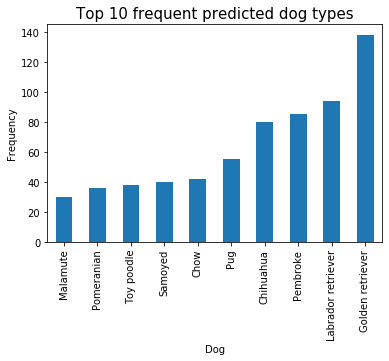

In [253]:
first_pre.p1.value_counts()[0:10].sort_values(ascending=True).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.title('Top 10 frequent predicted dog types', size=15)
plt.xlabel('Dog')
plt.plot();

In [238]:

# Store the prediction names of 10 most frequent predictions in a seperate variable
pred_name = first_pre.p1.value_counts().head(10).index.values
pred_name

array(['Golden retriever', 'Labrador retriever', 'Pembroke', 'Chihuahua',
       'Pug', 'Chow', 'Samoyed', 'Toy poodle', 'Pomeranian', 'Malamute'],
      dtype=object)

In [239]:

# Store the instances when algorithm's first prediction has been successful in a list
true_counts = []
for item in pred_name:
    x = first_pre[(first_pre.p1 == item) & (first_pre.p1_conf > 0.5) & (first_pre.p1_dog == True)]['p1_conf'].count()
    true_counts.append(x)
true_counts

[114, 64, 67, 48, 44, 26, 29, 23, 28, 18]

In [240]:

# Store the value counts of 10 most frequent predictions in a seperate variable
total_predictions = first_pre.p1.value_counts().head(10).values
total_predictions

array([138,  94,  85,  80,  55,  42,  40,  38,  36,  30], dtype=int64)

In [244]:

# Create a dataframe for the above 3 new variables
eff_dict = {'prediction_name': pred_name, 'prediction_total':total_predictions, 'prediction_correct':true_counts}
eff_result = pd.DataFrame(eff_dict, columns=['prediction_name', 'prediction_total', 'prediction_correct'])
eff_result

,prediction_name,prediction_total,prediction_correct
0,Golden retriever,138,114
1,Labrador retriever,94,64
2,Pembroke,85,67
3,Chihuahua,80,48
4,Pug,55,44
5,Chow,42,26
6,Samoyed,40,29
7,Toy poodle,38,23
8,Pomeranian,36,28
9,Malamute,30,18


In [245]:
# Calculate the prediction efficiency in a seperate column
eff_result['% correct prediction'] = (eff_result['prediction_correct'] / eff_result['prediction_total'])*100
eff_result

,prediction_name,prediction_total,prediction_correct,% correct prediction
0,Golden retriever,138,114,82.608696
1,Labrador retriever,94,64,68.085106
2,Pembroke,85,67,78.823529
3,Chihuahua,80,48,60.000000
4,Pug,55,44,80.000000
5,Chow,42,26,61.904762
6,Samoyed,40,29,72.500000
7,Toy poodle,38,23,60.526316
8,Pomeranian,36,28,77.777778
9,Malamute,30,18,60.000000


# 4. Text analysis

In [211]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [212]:
import gc # garbage collector

from collections import Counter # for counting commong words
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re # regular expression
import string # for finding punctuation in text
import nltk # preprocessing text
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PhuongAnh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [213]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [214]:
from textblob import TextBlob

In [215]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x) # then join the text again
# let's find out which stopwords need to remove. We'll use english stopwords.
i = nltk.corpus.stopwords.words('english')
# punctuations to remove
j = list(string.punctuation)
# finally let's combine all of these
stopwords = set(i).union(j)
data_df['text_clear'] = data_df['text'].apply(preprocess)

def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

data_df['senti_polarity'] = data_df['text_clear'].apply(sentiment)

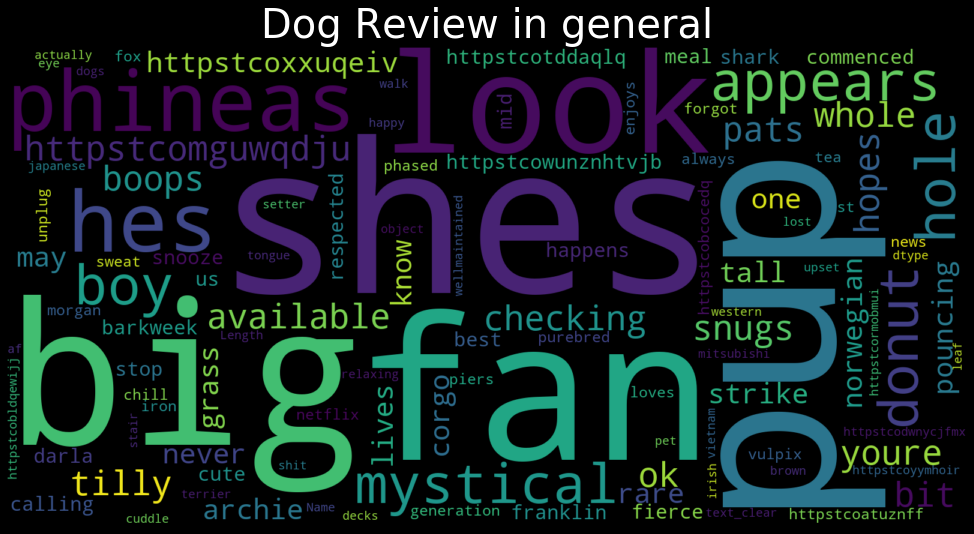

In [254]:
# difine wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
# generate word cloud
wc.generate(str(data_df['text_clear']))
# figure of graph
plt.figure(figsize=(20,10), facecolor='k')
# add the title to the graph
plt.title("Dog Review in general", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# finally show the plot
plt.show()

In [222]:
pupper = data_df[data_df['dog_stage'] == 'pupper']

In [223]:
pupper.count()

tweet_id              197
timestamp             197
source                197
text                  197
expanded_urls         197
rating_numerator      197
rating_denominator    197
name                  112
dog_stage             197
jpg_url               197
img_num               197
p1                    197
p1_conf               197
p1_dog                197
p2                    197
p2_conf               197
p2_dog                197
p3                    197
p3_conf               197
p3_dog                197
retweet_count         197
favorite_count        197
text_clear            197
senti_polarity        197
dtype: int64

In [224]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x) # then join the text again
# let's find out which stopwords need to remove. We'll use english stopwords.
i = nltk.corpus.stopwords.words('english')
# punctuations to remove
j = list(string.punctuation)
# finally let's combine all of these
stopwords = set(i).union(j)
pupper['text_clear'] = pupper['text'].apply(preprocess)

def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

pupper['senti_polarity'] = pupper['text_clear'].apply(sentiment)

C:\Users\PhuongAnh\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\PhuongAnh\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


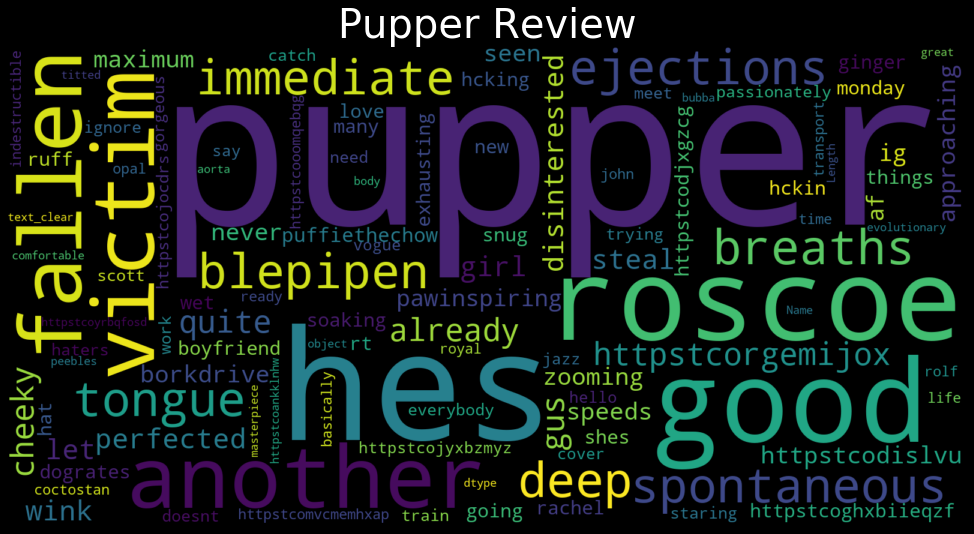

In [225]:
# difine wordcloud function from wordcloud library. set some parameteres for beatuful plotting
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
# generate word cloud
wc.generate(str(pupper['text_clear']))
# figure of graph
plt.figure(figsize=(20,10), facecolor='k')
# add the title to the graph
plt.title("Pupper Review", fontsize=40,color='white')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
# finally show the plot
plt.show()